In [1]:
import os
# Note: ensure notebook kernel is running in your project src directory.
os.chdir(os.path.expanduser('~/T-Retrievability/src/'))

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import convert, config, topical_eval

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [2]:
def compute_all_groupings_gini(modelname, kmeans_vec):
    result_csv_path = f'{config.proj_dir}/results/{modelname}_all_groupings_gini_{kmeans_vec}.csv'
    if os.path.exists(result_csv_path):
        return pd.read_csv(result_csv_path, index_col=0).reset_index()
    trec_file_path = f'{config.data_dir}/{modelname}_{config.dataset_name}_{config.topics_name}_{config.retrieve_num}.res'
    trec_df = convert.convert_res2docdf(trec_file_path, config.trec_res_columns)
    all_groupings = []
    for granu in config.num_clusters:
        clustered_queries_path = f'{config.proj_dir}/grouped_queries/clustered_dev_queries_by_{granu}_{kmeans_vec}.csv'
        print(f'computing for {clustered_queries_path}')
        cluster_q_df = pd.read_csv(clustered_queries_path, index_col=0).reset_index()
        cluster_q_df['qid'] = cluster_q_df['qid'].astype(str)
        min_gini, mean_gini, max_gini = topical_eval.calc_topical_gini(trec_df, cluster_q_df)
        all_groupings.append([modelname, granu, min_gini, mean_gini, max_gini])

    result_df = pd.DataFrame(all_groupings, columns=['modelname', 'granu', 'min_gini', 'mean_gini', 'max_gini'])
    
    print(f'saving into {result_csv_path}')
    result_df.to_csv(result_csv_path, index=False)
    print('done')

    return result_df

In [38]:
def sub_plot(plt, **params):
    kmeans_vec = params['kmeans_vec']
    x_locator = params['x_locator']
    y_locator = params['y_locator']
    y_lim = params['y_lim']
    col = params['col']
    ylabel = params['ylabel']
    title = params['title']

    bm25 = compute_all_groupings_gini("bm25", kmeans_vec)
    splade = compute_all_groupings_gini("splade", kmeans_vec)
    tctcolbert = compute_all_groupings_gini("tctcolbert", kmeans_vec)
    bm25_tctcolbert = compute_all_groupings_gini("bm25_tctcolbert", kmeans_vec)
    bm25_monot5 = compute_all_groupings_gini("bm25_monot5", kmeans_vec)

    plt.xaxis.set_major_locator(MultipleLocator(x_locator))
    plt.yaxis.set_major_locator(MultipleLocator(y_locator))
    plt.set_ylim(*y_lim)

    x = [1,2,3,4,5]
    y = bm25[col]
    line1, = plt.plot(x,y,label='BM25', marker='.', markersize=12)
    y = splade[col]
    line2, = plt.plot(x,y,label='SPLADE', marker='.', markersize=12)
    y = tctcolbert[col]
    line3, = plt.plot(x,y,label='TCT-ColBERT', marker='.', markersize=12)
    y = bm25_tctcolbert[col]
    line4, = plt.plot(x,y,label='BM25>>TCT-ColBERT', marker='.', markersize=12)
    y = bm25_monot5[col]
    line5, = plt.plot(x,y,label='BM25>>Mono-T5', marker='.', markersize=12)

    plt.set_title(title, fontsize=16)
    plt.set_xlabel(r'#Groups ($K$)', fontsize=16)

    plt.set_ylabel(ylabel, fontsize=16)
    plt.set_xticks(ticks = x, labels = ['500', '1000', '2000', '5000', '10000'], fontsize=16)
    return line1, line2,line3,line4,line5

In [39]:
def plot_1column_3graphs(axes, handles_list, ginis):
    fixed_size = (5, 4)
    x = [1,2,3,4,5]
    for ax, name, handles in zip(axes, ginis, handles_list):
        fig_single, ax_single = plt.subplots(figsize=fixed_size)
        for line in ax.get_lines():
            ax_single.plot(line.get_xdata(), line.get_ydata(),label=line.get_label(),color=line.get_color(),linestyle=line.get_linestyle(), marker='.', markersize=12)

        ax_single.set_xlim(ax.get_xlim())
        ax_single.set_ylim(ax.get_ylim())
        ax_single.autoscale(enable=False)
        ax_single.set_xticks(ticks = x, labels = ['500', '1000', '2000', '5000', '10000'], fontsize=16)
        ax_single.xaxis.set_major_locator(ax.xaxis.get_major_locator())
        ax_single.yaxis.set_major_locator(ax.yaxis.get_major_locator())
        ax_single.set_xlabel(ax.get_xlabel(), fontsize=16)
        ax_single.set_ylabel(ax.get_ylabel())
        ax_single.legend(handles=handles, loc='best', fontsize=10, frameon=True, facecolor="white", framealpha=0.8)
        fig_single.savefig(
            f"{config.proj_dir}/results/aggr_gini_{name}_{kmeans_vec}.pdf",
            format="pdf",
            bbox_inches='tight',
            pad_inches=0.2
        )
        plt.close(fig_single)

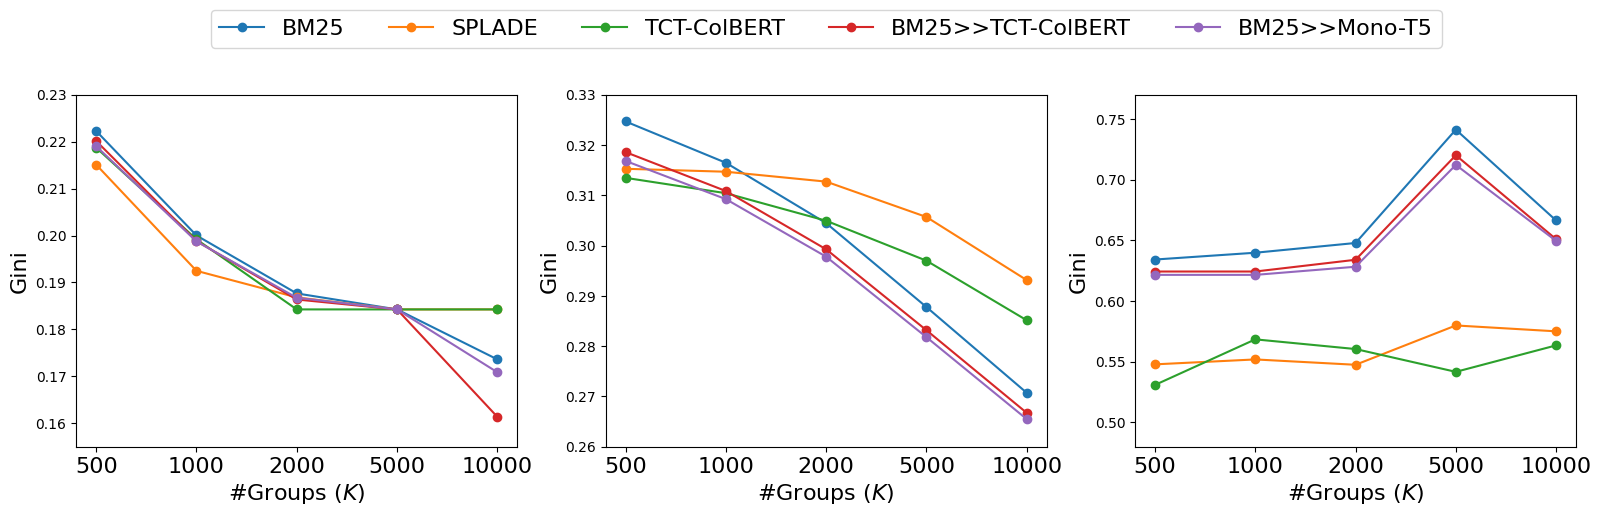

In [40]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplots_adjust(hspace=1, wspace=0.2, left=0, right=1, bottom=0)
kmeans_vec = 'scikit_dense'

params = {'kmeans_vec': kmeans_vec, 'col': 'min_gini', 'ylabel': 'Gini', 'x_locator': 1, 'y_locator': 0.01, 'y_lim': (0.155,0.23), 'title': None}
g0 = sub_plot(ax0, **params)
params = {'kmeans_vec': kmeans_vec, 'col': 'mean_gini', 'ylabel': 'Gini', 'x_locator': 1, 'y_locator': 0.01, 'y_lim': (0.26,0.33), 'title': None}
g1 = sub_plot(ax1, **params)
params = {'kmeans_vec': kmeans_vec, 'col': 'max_gini', 'ylabel': 'Gini', 'x_locator': 1, 'y_locator': 0.05, 'y_lim': (0.48,0.77), 'title': None}
g2 = sub_plot(ax2, **params)

fig.legend(handles=g0, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=10, fontsize=16)
plt.savefig(f'{config.proj_dir}/results/aggr_gini_{kmeans_vec}.png', format="png", bbox_inches="tight", pad_inches=0)
plt.show()

In [41]:
axes = [ax0, ax1, ax2]
handles_list = [g0, g1, g2]
ginis = ["min", "mean", "max"]
plot_1column_3graphs(axes, handles_list, ginis)

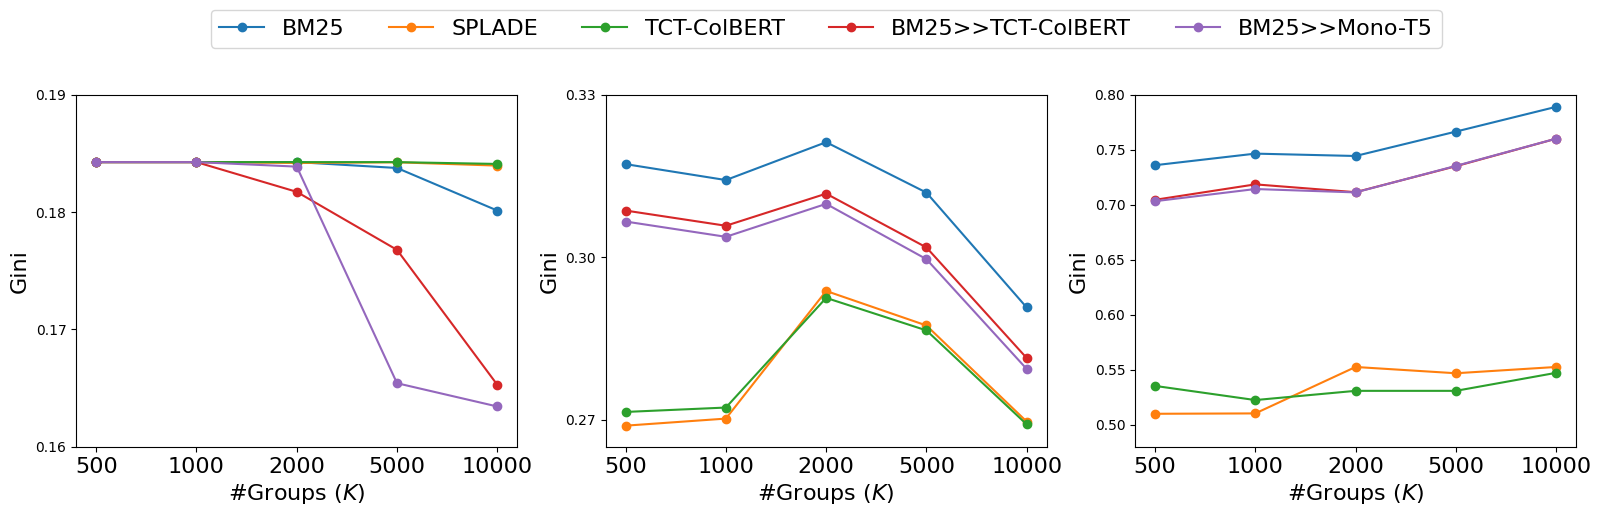

In [42]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplots_adjust(hspace=1, wspace=0.2, left=0, right=1, bottom=0)
kmeans_vec = 'scikit_tfidf'

params = {'kmeans_vec': kmeans_vec, 'col': 'min_gini', 'ylabel': 'Gini', 'x_locator': 1, 'y_locator': 0.01, 'y_lim': (0.16,0.19), 'title': None}
g0 = sub_plot(ax0, **params)
params = {'kmeans_vec': kmeans_vec, 'col': 'mean_gini', 'ylabel': 'Gini', 'x_locator': 1, 'y_locator': 0.03, 'y_lim': (0.265,0.33), 'title': None}
g1 = sub_plot(ax1, **params)
params = {'kmeans_vec': kmeans_vec, 'col': 'max_gini', 'ylabel': 'Gini', 'x_locator': 1, 'y_locator': 0.05, 'y_lim': (0.48,0.80), 'title': None}
g2 = sub_plot(ax2, **params)

fig.legend(handles=g0, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=10, fontsize=16)
plt.savefig(f'{config.proj_dir}/results/aggr_gini_{kmeans_vec}.png', format="png", bbox_inches="tight", pad_inches=0)
plt.show()

In [43]:
axes = [ax0, ax1, ax2]
handles_list = [g0, g1, g2]
ginis = ["min", "mean", "max"]
plot_1column_3graphs(axes, handles_list, ginis)